# Importing Necessary Libraries
This cell imports the required libraries and modules. These include:
- Libraries for image processing (`cv2`, `PIL.Image`) to handle and process CAPTCHA images.
- NumPy for numerical operations, and Matplotlib for visualizing the processed results.
- OS for file and directory operations.
These libraries are essential for preprocessing, segmenting, and analyzing CAPTCHA images.

In [37]:
import cv2
import numpy as np
import os
import torch
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

# Image Preprocessing and Contour Detection

This cell contains functions for loading a CAPTCHA image, preprocessing it for segmentation, and extracting character contours. The process involves:
- Converting the image to grayscale, smoothing, and thresholding to create a binarized image.
- Detecting contours and filtering them to isolate character regions.
- Splitting wide contours (joined characters) and merging nearby contours for better segmentation.
The output is a set of sorted, refined contours representing individual characters in the CAPTCHA.


In [38]:
def load_captcha_image(image_path):
    image = cv2.imread(image_path)
    return image


def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    smooth_image = cv2.medianBlur(gray, 5)
    thresh = cv2.adaptiveThreshold(smooth_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    kernel = np.ones((4, 4), np.uint8)

    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, kernel, iterations=1)

    return thresh


def merge_contours(contours, min_distance=12):
    bounding_boxes = [cv2.boundingRect(c) for c in contours]
    merged_boxes = []

    for box in bounding_boxes:
        x, y, w, h = box
        merged = False
        for i, (mx, my, mw, mh) in enumerate(merged_boxes):
            if abs(x - mx) < min_distance or abs((x + w) - (mx + mw)) < min_distance:
                merged_boxes[i] = (
                    min(x, mx), min(y, my), max(x + w, mx + mw) - min(x, mx), max(y + h, my + mh) - min(y, my))
                merged = True
                break
        if not merged:
            merged_boxes.append((x, y, w, h))
    merged_contours = [np.array([[x, y], [x + w, y], [x + w, y + h], [x, y + h]], dtype=np.int32) for (x, y, w, h) in
                       merged_boxes]

    return merged_contours


def split_wide_contours(contour, image, width_threshold=40):
    x, y, w, h = cv2.boundingRect(contour)
    if w > width_threshold:
        num_splits = int(np.ceil(w / width_threshold))
        segment_width = w // num_splits

        sub_contours = []
        for i in range(num_splits):
            sub_x = x + i * segment_width
            sub_w = segment_width if i < num_splits - 1 else w - (num_splits - 1) * segment_width
            sub_contour = np.array([[sub_x, y], [sub_x + sub_w, y], [sub_x + sub_w, y + h], [sub_x, y + h]],
                                   dtype=np.int32)
            sub_contours.append(sub_contour)
        return sub_contours
    else:
        return [contour]


def find_character_contours(thresh_image, width_threshold=40, expand_by=10):
    contours, _ = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    character_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if 5 < w and 5 < h:
            y = max(0, y - expand_by)
            h = h + 2 * expand_by

            split_contours = split_wide_contours(contour, thresh_image, width_threshold)
            for sc in split_contours:
                x_sc, y_sc, w_sc, h_sc = cv2.boundingRect(sc)
                expanded_contour = np.array([[x_sc, y], [x_sc + w_sc, y], [x_sc + w_sc, y + h], [x_sc, y + h]],
                                            dtype=np.int32)
                character_contours.append(expanded_contour)

    character_contours = sorted(character_contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
    merged_contours = merge_contours(character_contours)

    return merged_contours


# Visualization of Segmentation and Extracted Characters

This cell provides functions to visualize the results of the CAPTCHA segmentation process:

- **`visualize_segmentation`**: Draws bounding boxes around detected contours on the original CAPTCHA image, scaled for visualization. This helps verify if the contours correctly isolate characters.
  
- **`visualize_extracted_characters`**: Displays individual extracted character images, resized and thresholded, to ensure proper segmentation. This is useful for debugging and confirming that each character has been correctly isolated.

In [39]:
def visualize_segmentation(image, contours, preprocessed_image):
    scaled_image = cv2.resize(image, (400, 100))
    image_with_boxes = scaled_image.copy()

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        scale_x = scaled_image.shape[1] / image.shape[1]
        scale_y = scaled_image.shape[0] / image.shape[0]
        cv2.rectangle(image_with_boxes,
                      (int(x * scale_x), int(y * scale_y)),
                      (int((x + w) * scale_x), int((y + h) * scale_y)),
                      (0, 255, 0), 2)

    rgb_image_with_boxes = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_image_with_boxes)
    plt.axis('off')
    plt.title('Original Image with Contours')


def visualize_extracted_characters(image, contours, target_size=(28, 28)):
    plt.figure(figsize=(4, 1))
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        char_image = image[y:y + h, x:x + w]

        char_image_resized = cv2.resize(char_image, target_size)
        gray = cv2.cvtColor(char_image_resized, cv2.COLOR_BGR2GRAY)
        smooth_image = cv2.medianBlur(gray, 5)
        thresh = cv2.adaptiveThreshold(smooth_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 11, 2)
        plt.subplot(1, len(contours), i + 1)
        plt.imshow(thresh, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# CAPTCHA Processing Pipeline

This cell defines the main workflow for processing CAPTCHA images:
- **`process_captcha`**: Handles the end-to-end processing of a CAPTCHA image by:
  1. Loading the image.
  2. Preprocessing it for segmentation.
  3. Detecting and visualizing character contours.
  4. Displaying the extracted characters for verification.

- The script iterates through a small subset of CAPTCHA images from the specified directory, processes each image using `process_captcha`, and visualizes the results.

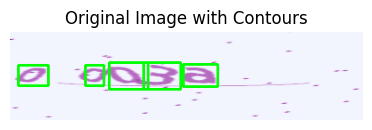

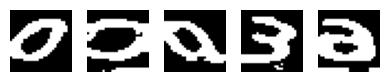

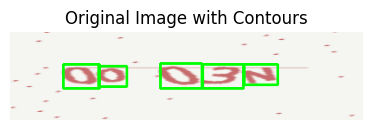

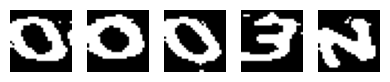

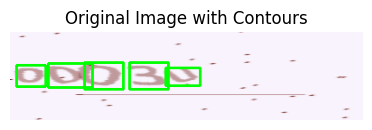

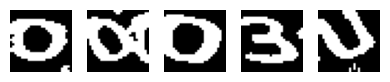

In [ ]:
def process_captcha(image_path):
    image = load_captcha_image(image_path)
    thresh_image = preprocess_image(image)
    contours = find_character_contours(thresh_image)

    visualize_segmentation(image, contours, thresh_image)
    visualize_extracted_characters(image, contours)

    image_name = os.path.splitext(os.path.basename(image_path))[0]


input_dir = '../../data'
image_files = os.listdir(input_dir)[:3]

for image_file in image_files:
    image_path = os.path.join(input_dir, image_file)
    process_captcha(image_path)
